In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import numpy as np
import os
os.environ["JAXTYPING_DISABLE"] = "1"
import torch
import skshapes as sks
from matplotlib.path import Path

# Fonctions utilitaires

In [140]:
# FONCTION DE RÉTRACTION
def apply_retraction(points, center, strength, radius_influence):
    """
    Simule la contraction des tissus vers un centre (brûlure).
    """
    vectors = points - center
    distances = np.linalg.norm(vectors, axis=1)
    
    # Sécurité division par zéro
    distances[distances == 0] = 0.001
    normalized_vectors = vectors / distances[:, None]
    
    # Formule Gaussienne inversée
    displacement_magnitude = strength * distances * np.exp(- (distances**2) / (2 * radius_influence**2))
    
    # Déplacement VERS le centre
    new_points = points - (normalized_vectors * displacement_magnitude[:, None])
    return new_points

# GENERATION DES FORMES JOUET
# 1) Foie en forme de haricot
def get_liver_shape(n_points=400):
    t = np.linspace(0, 2*np.pi, n_points)
    # Forme "Haricot"
    x = 10 * (np.cos(t) + 0.2 * np.cos(2*t))
    y = 8 * (np.sin(t) - 0.1 * np.sin(2*t))
    return np.column_stack((x, y))

# 2) Zone d'abalation ou tumeur en forme de cercle
def get_circle(center, radius, n_points=100):
    t = np.linspace(0, 2*np.pi, n_points)
    x = center[0] + radius * np.cos(t)
    y = center[1] + radius * np.sin(t)
    return np.column_stack((x, y))

# 3) Vaisseau en arc de cercle
def get_arc_vessel(center_ablation, radius_vessel, start_angle, end_angle, n_points=60):
    """
    Crée un vaisseau principal en arc de cercle autour de l'ablation
    + une branche qui part vers l'extérieur.
    """
    t = np.linspace(np.radians(start_angle), np.radians(end_angle), n_points)
    arc_x = center_ablation[0] + radius_vessel * np.cos(t)
    arc_y = center_ablation[1] + radius_vessel * np.sin(t)
    arc = np.column_stack((arc_x, arc_y))
    
    return arc

# CONVERSION D'UN OBJET NUMY EN POLYDATA
def curve_to_polydata(points_2d, is_closed=False):
    """
    Convertit une liste de points 2D (x, y) en un objet PyVista PolyData (x, y, z=0).
    is_closed=True -> Relie le dernier point au premier (pour le Foie/Ablation)
    is_closed=False -> Laisse ouvert (pour les Vaisseaux)
    """
    n_points = len(points_2d)
    
    # 1. Ajouter la dimension Z=0
    points_3d = np.column_stack((points_2d, np.zeros(n_points)))
    
    # 2. Créer la connectivité (Lignes)
    # Pour PyVista, une ligne se définit par : [Nombre_de_points, idx0, idx1, idx2...]
    if is_closed:
        # On ferme la boucle : 0->1->...->N->0
        # On crée une seule cellule qui contient tous les points
        cells = np.r_[n_points, np.arange(n_points)]
        # Note : PyVista comprend qu'il faut fermer si on utilise 'lines' correctement ou via constructeur
        # Méthode explicite ligne par ligne pour compatibilité maximale :
        lines = np.column_stack((
            np.full(n_points, 2),       # Chaque segment a 2 points
            np.arange(n_points),        # Point A
            np.roll(np.arange(n_points), -1) # Point B (le dernier se lie au premier)
        )).ravel()
    else:
        # Ligne ouverte : 0->1->...->N
        # On relie i à i+1
        lines = np.column_stack((
            np.full(n_points - 1, 2),
            np.arange(n_points - 1),
            np.arange(1, n_points)
        )).ravel()

    # 3. Création de l'objet PolyData
    mesh = pv.PolyData(points_3d)
    mesh.lines = lines
    return mesh

# FUSION DE PLUSIEURS VAISSEAUX
def merge_vessels(list_of_vessel_arrays):
    """Fusionne une liste de vaisseaux (tableaux numpy) en un seul Mesh PolyData"""
    combined_mesh = pv.PolyData()
    for v_points in list_of_vessel_arrays:
        v_mesh = curve_to_polydata(v_points, is_closed=False)
        combined_mesh += v_mesh # Fusion VTK automatique
    return combined_mesh

# VISUALISATEUR AVANT/APRÈS AVEC GRILLE DE DÉFORMATION
def visualiser_zoom_grid(source, target, morphed, window_size=(1200, 600)):
    """
    Affiche une comparaison Avant/Après avec la grille de déformation visible.
    
    Args:
        source: PolyData (Avant déformation)
        target: PolyData (Cible)
        morphed: PolyData (Résultat déformé)
        model: L'objet modèle (pour récupérer le scale)
    """
    source_color = "teal"
    target_color = "red"

    plotter = pv.Plotter(shape=(1, 2), window_size=window_size)

    # --- GAUCHE : AVANT ---
    plotter.subplot(0, 0)
    plotter.add_text("Source non recalée VS cible", font_size=10, color="black")

    # Affichage de la grille en fil de fer (SANS LES POINTS NOIRS)
    if hasattr(source, "control_points"):
        plotter.add_mesh(source.control_points.to_pyvista(), color="black", 
                         style="wireframe", line_width=1, opacity=0.4)
        # J'ai retiré le bloc qui ajoutait les points ici

    plotter.add_mesh(source.to_pyvista(), color=source_color, opacity=0.7, line_width=2, label="Source non recalée")
    plotter.add_mesh(target.to_pyvista(), color=target_color, style="wireframe", line_width=2, label="Cible")
    
    plotter.add_legend()
    plotter.view_xy()
    plotter.enable_2d_style() # Pour bloquer la rotation 3D

    # --- DROITE : APRÈS ---
    plotter.subplot(0, 1)
    plotter.add_text("Source recalée VS cible", font_size=10, color="black")

    if hasattr(morphed, "control_points"):
        # On voit bien comment la grille fine s'est tordue
        plotter.add_mesh(morphed.control_points.to_pyvista(), color="black", 
                         style="wireframe", line_width=1, opacity=0.4)

    plotter.add_mesh(morphed.to_pyvista(), color=source_color, opacity=0.7, line_width=2, label="Source recalée")
    plotter.add_mesh(target.to_pyvista(), color=target_color, style="wireframe", line_width=2, label="Cible")
    
    plotter.add_legend()
    plotter.view_xy()
    plotter.enable_2d_style() # Pour bloquer la rotation 3D

    # Finalisation
    plotter.link_views()
    plotter.show()

def visualiser_validation_only(verite_terrain, resultat_recale, window_size=(1000, 1000)):
    """
    Version ultra-simplifiée.
    Affiche uniquement la superposition : Vérité Terrain (Bleu) vs Résultat (Rouge).
    """
    
    # 1. Conversion de sécurité (accepte Scikit-Shapes ou PyVista)
    # Si c'est du Scikit-Shapes, on convertit. Sinon on garde tel quel.
    pv_verite = verite_terrain.to_pyvista() if hasattr(verite_terrain, "to_pyvista") else verite_terrain
    pv_resultat = resultat_recale.to_pyvista() if hasattr(resultat_recale, "to_pyvista") else resultat_recale

    # 2. Création de la fenêtre
    pl = pv.Plotter(window_size=window_size)
    pl.add_text("VALIDATION FINALE (De-Rétractation)", font_size=12, color="black")
    
    # A. Vérité Terrain (Bleu) en mode "Fil de fer" standard
    pl.add_mesh(pv_verite, color="blue", style="wireframe", line_width=2, label="Vérité Terrain")
    
    # B. Résultat (Rouge) en mode "Surface" transparente
    pl.add_mesh(pv_resultat, color="red", opacity=0.5, show_edges=False, label="Zone Corrigée")
    
    # 3. Affichage 2D
    pl.add_legend()
    pl.view_xy()          # Vue de dessus
    pl.enable_2d_style()  # Bloque la rotation 3D
    
    pl.show()

def visualiser_intervention(
    foie_pre, zone_ablation_pre, tumeur_pre, vaisseaux_pre,
    foie_post, zone_ablation_post, vaisseaux_post,
    figsize=(12, 6)
):
    """
    Affiche une comparaison côte à côte des états pré-opératoire et post-opératoire
    pour le foie, la tumeur, la zone d'ablation et les vaisseaux.
    """
    plt.figure(figsize=figsize)

    # --- GAUCHE : PRÉ-OP ---
    plt.subplot(1, 2, 1)
    plt.title("Pré-op")
    
    # Structures statiques
    plt.plot(foie_pre[:,0], foie_pre[:,1], 'k-', lw=1, label='Foie')
    plt.fill(zone_ablation_pre[:,0], zone_ablation_pre[:,1], 'r', alpha=0.5, label='Zone Ablation (ground truth)')
    plt.fill(tumeur_pre[:,0], tumeur_pre[:,1], 'k', label='Tumeur')

    # Boucle sur les vaisseaux
    for i, v in enumerate(vaisseaux_pre):
        # On ne met le label que sur le premier pour ne pas polluer la légende
        label = "Vaisseau" if i == 0 else ""
        plt.plot(v[:,0], v[:,1], 'b-', lw=3, label=label)

    plt.axis('equal')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # --- DROITE : POST-OP ---
    plt.subplot(1, 2, 2)
    plt.title("Post-op")
    
    # Structures statiques
    plt.plot(foie_post[:,0], foie_post[:,1], 'k-', lw=1, label='Foie')
    plt.fill(zone_ablation_post[:,0], zone_ablation_post[:,1], 'r', alpha=0.5, label='Zone Ablation')

    # Boucle sur les vaisseaux déformés
    for i, v in enumerate(vaisseaux_post):
        label = "Vaisseau" if i == 0 else ""
        plt.plot(v[:,0], v[:,1], 'b-', lw=3, label=label)

    plt.axis('equal')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Création des données "jouet"

In [141]:
# DEFINITION DES PARAMETRES DES OBJETS JOUET
# Tumeur
centre_tumeur = np.array([3.0, 2.0])
rayon_tumeur = 1.5

# Zone d'ablation
marge = 1.0  # 1 cm
rayon_ablation = rayon_tumeur + marge

# Paramètres de la rétractation (ground truth)
FORCE_RETRACTATION = 1 # Assez fort pour être visible
RAYON_INFLUENCE = rayon_ablation # Assez large pour toucher les vaisseaux

# Vaisseau A
start_angle_A = 0
end_angle_A = 360
rayon_vaisseau_A = rayon_ablation + 0.5  # Positionné à l'extérieur de la zone d'ablation

# Vaisseau B
start_angle_B = 0
end_angle_B = 180
rayon_vaisseau_B = rayon_ablation + 0.5  # Positionné à l'extérieur de la zone d'ablation

# CREATION DES OBJETS JOUET (PRE-OP)
# Foie
foie_pre = get_liver_shape()

# Tumeur
tumeur_pre = get_circle(centre_tumeur, rayon_tumeur)

# Zone d'Ablation (ground truth)
zone_ablation_pre = get_circle(centre_tumeur, rayon_ablation)

# Réseau de vaisseaux 1
arc_pre_A = get_arc_vessel(centre_tumeur, radius_vessel=rayon_vaisseau_A, start_angle=start_angle_A,  end_angle=end_angle_A)
vaisseaux_pre_1 = [arc_pre_A]

# Réseau de vaisseaux 2
arc_pre_B = get_arc_vessel(centre_tumeur, radius_vessel=rayon_vaisseau_B, start_angle=start_angle_B,  end_angle=end_angle_B)
vaisseaux_pre_2 = [arc_pre_B]

# --- NOUVEAUX PARAMÈTRES ---
NOMBRE_ARCS = 30          # On passe à 30 arcs
ANGLE_OUVERTURE = 22.5    # Arcs plus petits (22.5 degrés)
DIST_MAX_DU_CENTRE = 12  # J'ai légèrement augmenté pour bien remplir tout le foie

# On récupère le contour pour les tests (au cas où ce n'est pas déjà fait)
path_foie = Path(foie_pre)

vaisseaux_pre_3 = []

# --- BOUCLE DE GÉNÉRATION ---
compteur_securite = 0
while len(vaisseaux_pre_3) < NOMBRE_ARCS and compteur_securite < 2000:
    compteur_securite += 1
    
    # 1. Tirage aléatoire
    # Rayon : Toujours hors de la zone d'ablation (+1 marge), jusqu'au bord
    r_alea = np.random.uniform(rayon_ablation + 1, DIST_MAX_DU_CENTRE)
    
    # Angle
    angle_start_alea = np.random.uniform(0, 360)
    angle_end_alea = angle_start_alea + ANGLE_OUVERTURE
    
    # 2. Création de l'arc candidat
    arc_candidat = get_arc_vessel(
        centre_tumeur, 
        radius_vessel=r_alea, 
        start_angle=angle_start_alea, 
        end_angle=angle_end_alea
    )
    
    # 3. Vérification : Dedans ou Dehors ?
    is_inside = path_foie.contains_points(arc_candidat)
    
    # On garde seulement si TOUT l'arc est dans le foie
    if np.all(is_inside):
        vaisseaux_pre_3.append(arc_candidat)

# SIMULATION DE L'INTERVENTION (POST-OP)
# On applique ta fonction apply_retraction à TOUT le monde
foie_post = apply_retraction(foie_pre, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)

# Note: La tumeur n'existe plus physiquement, mais on calcule la déformation de l'espace
# La zone d'ablation visible est la version rétractée de la zone théorique
zone_ablation_post = apply_retraction(zone_ablation_pre, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)

vaisseaux_post_1 = []
for segment in vaisseaux_pre_1:
    seg_post = apply_retraction(segment, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)
    vaisseaux_post_1.append(seg_post)

vaisseaux_post_2 = []
for segment in vaisseaux_pre_2:
    seg_post = apply_retraction(segment, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)
    vaisseaux_post_2.append(seg_post)

# --- SIMULATION POST-OP ---
vaisseaux_post_3 = []
for segment in vaisseaux_pre_3:
    seg_post = apply_retraction(segment, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)
    vaisseaux_post_3.append(seg_post)

# Conversion en objets polydata

In [142]:
# CRÉATION DES COMPOSANTS DE BASE
# On utilise les variables générées dans l'étape précédente :
# foie_pre, foie_post, vaisseaux_pre, vaisseaux_post, zone_ablation_pre, zone_ablation_post

# -- PRE-OP --
mesh_foie_pre = curve_to_polydata(foie_pre, is_closed=True)
mesh_vaisseaux_pre_1 = merge_vessels(vaisseaux_pre_1)
mesh_vaisseaux_pre_2 = merge_vessels(vaisseaux_pre_2)
mesh_vaisseaux_pre_3 = merge_vessels(vaisseaux_pre_3)
mesh_ablation_pre = curve_to_polydata(zone_ablation_pre, is_closed=True)

# -- POST-OP --
mesh_foie_post = curve_to_polydata(foie_post, is_closed=True)
mesh_vaisseaux_post_1 = merge_vessels(vaisseaux_post_1)
mesh_vaisseaux_post_2 = merge_vessels(vaisseaux_post_2)
mesh_vaisseaux_post_3 = merge_vessels(vaisseaux_post_3)
mesh_ablation_post = curve_to_polydata(zone_ablation_post, is_closed=True)


# ASSEMBLAGE DES STRUCTURES COMPLÈTES

# Structures registration SOURCE (Pre-Op : Foie + Vaisseaux)
structure_1_pre_reg = mesh_foie_pre + mesh_vaisseaux_pre_1
structure_2_pre_reg = mesh_foie_pre + mesh_vaisseaux_pre_2
structure_3_pre_reg = mesh_foie_pre + mesh_vaisseaux_pre_3

# Structures registration TARGET (Post-Op : Foie + Vaisseaux)
structure_1_post_reg = mesh_foie_post + mesh_vaisseaux_post_1
structure_2_post_reg = mesh_foie_post + mesh_vaisseaux_post_2
structure_3_post_reg = mesh_foie_post + mesh_vaisseaux_post_3

# Structure validation SOURCE (Pre-Op : Foie + Vaisseaux + Ablation)
# Celle-ci sert de "Vérité Terrain" complète
structure_pre_full = mesh_foie_pre + mesh_ablation_pre

# Structure validation TARGET (Post-Op : Foie + Vaisseaux + Ablation)
# Celle-ci sert à vérifier visuellement la rétractation avant correction
structure_post_full = mesh_foie_post + mesh_ablation_post

# Simulation 1 : scénario du pire, on n'a accès qu'à la déformation du foie

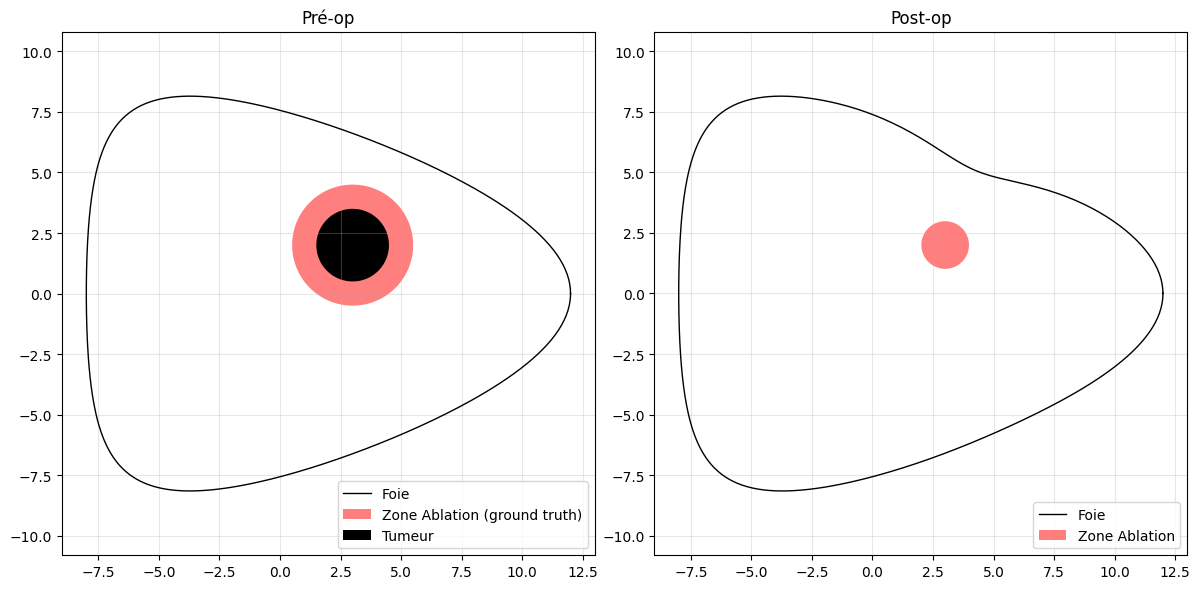

Nombre de points de contrôle : 625
Début du recalage Haute Définition...
Initial loss : 2.87e-02
  = 2.87e-02 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 8.22e-04
  = 2.18e-04 + 0.001 * 6.04e-01 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 7.94e-04
  = 1.96e-04 + 0.001 * 5.98e-01 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 7.79e-04
  = 1.74e-04 + 0.001 * 6.06e-01 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 7.74e-04
  = 1.67e-04 + 0.001 * 6.07e-01 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 7.74e-04
  = 1.67e-04 + 0.001 * 6.07e-01 (fidelity + regularization_weight * regularization)
Terminé !


Widget(value='<iframe src="http://localhost:53897/index.html?ui=P_0x336ac76b0_72&reconnect=auto" class="pyvist…

In [143]:
visualiser_intervention(
    foie_pre, 
    zone_ablation_pre, 
    tumeur_pre, 
    [],  # Votre liste spécifique de vaisseaux
    foie_post, 
    zone_ablation_post, 
    []
)

# 1. CHARGEMENT
source = sks.PolyData(mesh_foie_pre)
target = sks.PolyData(mesh_foie_post)

# =========================================================
# 2. DEFINITION DE LA GRILLE FINE (REFINE)
# =========================================================

# N=25 : On passe d'une grille grossière (10x10) à une grille fine (~25x25)
# offset=0.2 : On serre la grille au maximum autour de l'objet (marge minuscule)
source.control_points = source.bounding_grid(N=25, offset=0.2)

# =========================================================
# 3. MODÈLE ADAPTÉ (Fine Scale)
# =========================================================

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    # IMPORTANT : Comme les points sont plus rapprochés, on réduit le scale.
    # Scale doit être environ 1.5x à 2x l'écartement des points de la grille.
    scale=1.5, 
    control_points=True
)

loss = sks.OptimalTransportLoss()


registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=5, # On augmente un peu les itérations car il y a plus de paramètres à régler
    verbose=True,
    regularization_weight=0.001 
)

print(f"Nombre de points de contrôle : {source.control_points.n_points}")
print("Début du recalage Haute Définition...")
morphed = registration.fit_transform(source=source, target=target)
print("Terminé !")

visualiser_zoom_grid(source, target, morphed)

# Simulation 2 : scénario idéal, un vaisseau fait le tour de la zone d'ablation

## 1) Registration pre-op -> post-op

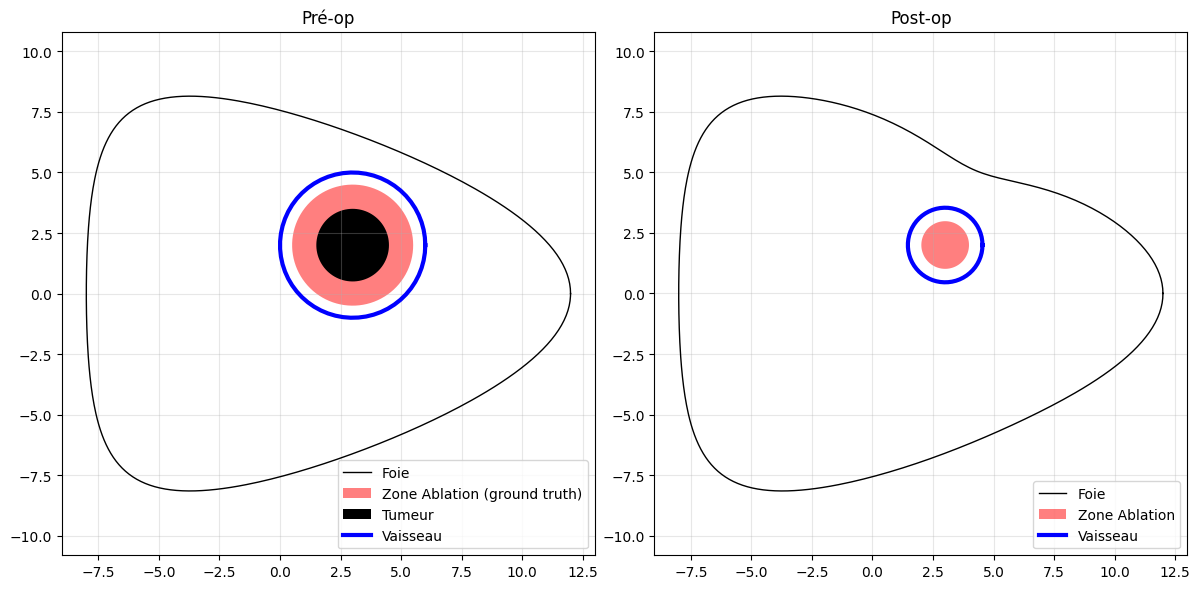

Nombre de points de contrôle : 625
Début du recalage Haute Définition...
Initial loss : 4.32e-01
  = 4.32e-01 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 5.59e-03
  = 1.63e-04 + 0.001 * 5.43e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 5.48e-03
  = 1.33e-04 + 0.001 * 5.35e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 5.48e-03
  = 1.33e-04 + 0.001 * 5.35e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 5.48e-03
  = 1.33e-04 + 0.001 * 5.35e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 5.48e-03
  = 1.33e-04 + 0.001 * 5.35e+00 (fidelity + regularization_weight * regularization)
Terminé !


Widget(value='<iframe src="http://localhost:53897/index.html?ui=P_0x3a80eef90_73&reconnect=auto" class="pyvist…

In [144]:
visualiser_intervention(
    foie_pre, 
    zone_ablation_pre, 
    tumeur_pre, 
    vaisseaux_pre_1,  # Votre liste spécifique de vaisseaux
    foie_post, 
    zone_ablation_post, 
    vaisseaux_post_1
)

# 1. CHARGEMENT
source = sks.PolyData(structure_1_pre_reg)
target = sks.PolyData(structure_1_post_reg)

# =========================================================
# 2. DEFINITION DE LA GRILLE FINE (REFINE)
# =========================================================

# N=25 : On passe d'une grille grossière (10x10) à une grille fine (~25x25)
# offset=0.2 : On serre la grille au maximum autour de l'objet (marge minuscule)
source.control_points = source.bounding_grid(N=25, offset=0.2)

# =========================================================
# 3. MODÈLE ADAPTÉ (Fine Scale)
# =========================================================

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    # IMPORTANT : Comme les points sont plus rapprochés, on réduit le scale.
    # Scale doit être environ 1.5x à 2x l'écartement des points de la grille.
    scale=1.5, 
    control_points=True
)

loss = sks.OptimalTransportLoss()

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=5, # On augmente un peu les itérations car il y a plus de paramètres à régler
    verbose=True,
    regularization_weight=0.001 
)

print(f"Nombre de points de contrôle : {source.control_points.n_points}")
print("Début du recalage Haute Définition...")
morphed = registration.fit_transform(source=source, target=target)
print("Terminé !")

visualiser_zoom_grid(source, target, morphed)

## 2) Estimation de la zone d'ablation

In [145]:
source = sks.PolyData(structure_1_post_reg)
target = sks.PolyData(structure_1_pre_reg)

source.control_points = source.bounding_grid(N=25, offset=0.2)

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    scale=1.5,  # Scale fin pour capturer la courbure des vaisseaux
    control_points=True
)

loss = sks.OptimalTransportLoss()

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=5,
    verbose=True,
    regularization_weight=0.001 
)

print("--- DÉBUT DU RECALAGE INVERSE (Post -> Pre) ---")
# On déforme le Post-Op pour qu'il "gonfle" et revienne sur le Pre-Op
registration.fit(source=source, target=target)
print("--- RECALAGE TERMINÉ ---")

# 1. On charge la forme complète Post-Op
structure_validation_source = sks.PolyData(structure_post_full)

# 2. ON GREFFE LA GRILLE (Indispensable)
# On réutilise la grille qui a servi à calculer la déformation
structure_validation_source.control_points = source.control_points

print("Application de la déformation...")

# 3. MORPHING
# On utilise parameter_ et on récupère l'objet résultat
morphing_output = registration.model.morph(
    shape=structure_validation_source,
    parameter=registration.parameter_
)

# 4. EXTRACTION DE LA FORME
# C'est ici qu'on récupère le vrai objet PolyData
structure_finale = morphing_output.morphed_shape

print("✅ Déformation appliquée et forme extraite !")

visualiser_validation_only(
    verite_terrain=structure_pre_full, 
    resultat_recale=structure_finale
)

--- DÉBUT DU RECALAGE INVERSE (Post -> Pre) ---
Initial loss : 4.32e-01
  = 4.32e-01 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 5.79e-03
  = 2.65e-04 + 0.001 * 5.52e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 5.54e-03
  = 1.84e-04 + 0.001 * 5.35e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 5.51e-03
  = 1.79e-04 + 0.001 * 5.33e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 5.51e-03
  = 1.79e-04 + 0.001 * 5.33e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 5.51e-03
  = 1.79e-04 + 0.001 * 5.33e+00 (fidelity + regularization_weight * regularization)
--- RECALAGE TERMINÉ ---
Application de la déformation...
✅ Déformation appliquée et forme extraite !


Widget(value='<iframe src="http://localhost:53897/index.html?ui=P_0x40f494a40_74&reconnect=auto" class="pyvist…

# Simulation 3 : scénario intermédiaire, un vaisseau ne passe que d'un côté de la zone d'ablation

## 1) Registration pre-op -> post-op

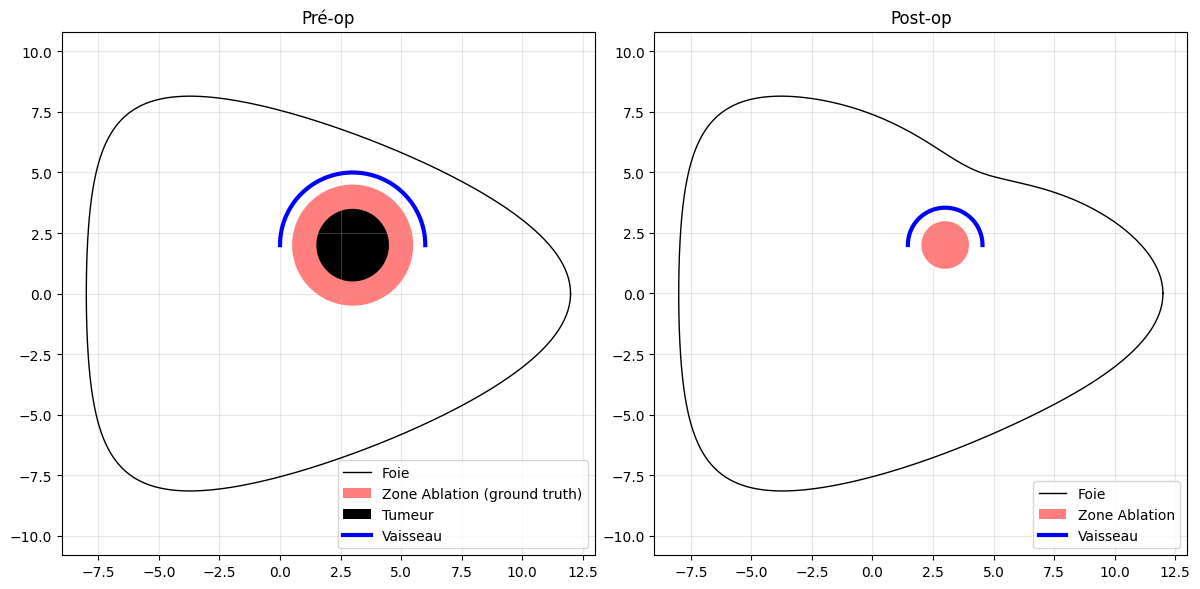

Nombre de points de contrôle : 625
Début du recalage Haute Définition...
Initial loss : 2.62e-01
  = 2.62e-01 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 4.03e-03
  = 3.21e-04 + 0.001 * 3.71e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 3.91e-03
  = 2.70e-04 + 0.001 * 3.64e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 3.87e-03
  = 2.53e-04 + 0.001 * 3.62e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 3.87e-03
  = 2.53e-04 + 0.001 * 3.62e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 3.87e-03
  = 2.53e-04 + 0.001 * 3.62e+00 (fidelity + regularization_weight * regularization)
Terminé !


Widget(value='<iframe src="http://localhost:53897/index.html?ui=P_0x336dd7260_75&reconnect=auto" class="pyvist…

In [146]:
visualiser_intervention(
    foie_pre, 
    zone_ablation_pre, 
    tumeur_pre, 
    vaisseaux_pre_2,  # Votre liste spécifique de vaisseaux
    foie_post, 
    zone_ablation_post, 
    vaisseaux_post_2
)

# 1. CHARGEMENT
source = sks.PolyData(structure_2_pre_reg)
target = sks.PolyData(structure_2_post_reg)

# =========================================================
# 2. DEFINITION DE LA GRILLE FINE (REFINE)
# =========================================================

# N=25 : On passe d'une grille grossière (10x10) à une grille fine (~25x25)
# offset=0.2 : On serre la grille au maximum autour de l'objet (marge minuscule)
source.control_points = source.bounding_grid(N=25, offset=0.2)

# =========================================================
# 3. MODÈLE ADAPTÉ (Fine Scale)
# =========================================================

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    # IMPORTANT : Comme les points sont plus rapprochés, on réduit le scale.
    # Scale doit être environ 1.5x à 2x l'écartement des points de la grille.
    scale=1.5, 
    control_points=True
)

loss = sks.OptimalTransportLoss()

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=5, # On augmente un peu les itérations car il y a plus de paramètres à régler
    verbose=True,
    regularization_weight=0.001 
)

print(f"Nombre de points de contrôle : {source.control_points.n_points}")
print("Début du recalage Haute Définition...")
morphed = registration.fit_transform(source=source, target=target)
print("Terminé !")

visualiser_zoom_grid(source, target, morphed)

## 2) Estimation de la zone d'ablation

In [147]:
source = sks.PolyData(structure_2_post_reg)
target = sks.PolyData(structure_2_pre_reg)

source.control_points = source.bounding_grid(N=25, offset=0.2)

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    scale=1.5,  # Scale fin pour capturer la courbure des vaisseaux
    control_points=True
)

loss = sks.OptimalTransportLoss()

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=5,
    verbose=True,
    regularization_weight=0.001 
)

print("--- DÉBUT DU RECALAGE INVERSE (Post -> Pre) ---")
# On déforme le Post-Op pour qu'il "gonfle" et revienne sur le Pre-Op
registration.fit(source=source, target=target)
print("--- RECALAGE TERMINÉ ---")

# 1. On charge la forme complète Post-Op
structure_validation_source = sks.PolyData(structure_post_full)

# 2. ON GREFFE LA GRILLE (Indispensable)
# On réutilise la grille qui a servi à calculer la déformation
structure_validation_source.control_points = source.control_points

print("Application de la déformation...")

# 3. MORPHING
# On utilise parameter_ et on récupère l'objet résultat
morphing_output = registration.model.morph(
    shape=structure_validation_source,
    parameter=registration.parameter_
)

# 4. EXTRACTION DE LA FORME
# C'est ici qu'on récupère le vrai objet PolyData
structure_finale = morphing_output.morphed_shape

print("✅ Déformation appliquée et forme extraite !")

visualiser_validation_only(
    verite_terrain=structure_pre_full, 
    resultat_recale=structure_finale
)

--- DÉBUT DU RECALAGE INVERSE (Post -> Pre) ---
Initial loss : 2.62e-01
  = 2.62e-01 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 4.51e-03
  = 6.24e-04 + 0.001 * 3.89e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 4.14e-03
  = 4.34e-04 + 0.001 * 3.71e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 4.09e-03
  = 4.34e-04 + 0.001 * 3.65e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 4.06e-03
  = 4.15e-04 + 0.001 * 3.64e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 4.06e-03
  = 4.15e-04 + 0.001 * 3.64e+00 (fidelity + regularization_weight * regularization)
--- RECALAGE TERMINÉ ---
Application de la déformation...
✅ Déformation appliquée et forme extraite !


Widget(value='<iframe src="http://localhost:53897/index.html?ui=P_0x32aa2ade0_76&reconnect=auto" class="pyvist…

# Simulation 4 : scénario réaliste avec des vaisseaux répartis dans le foie

## 1) Registration pre-op -> post-op

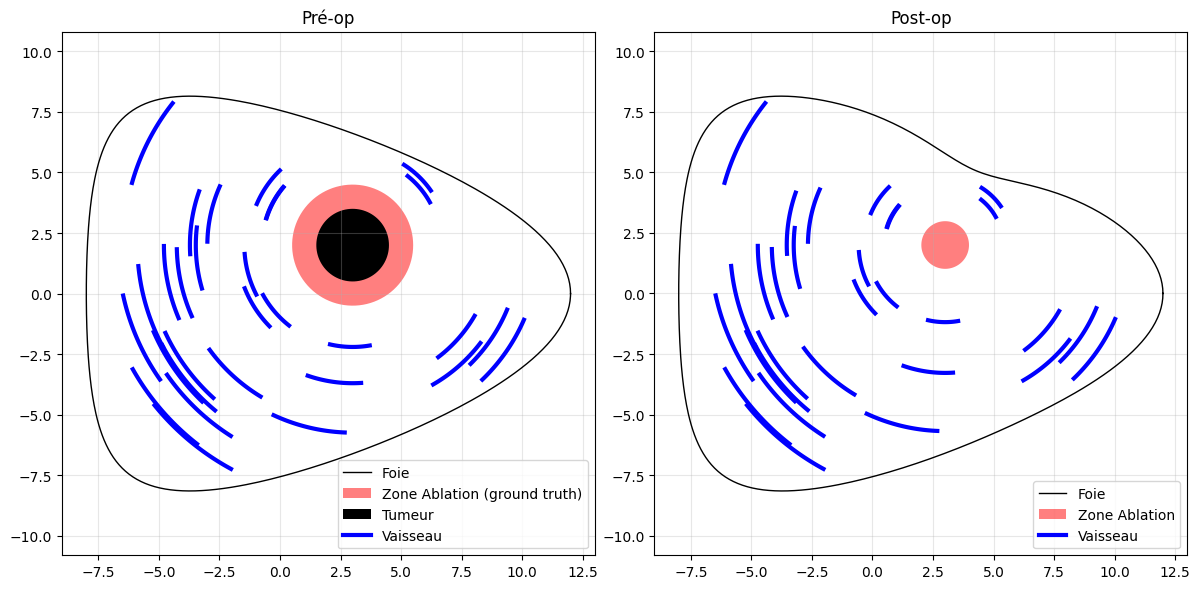

Nombre de points de contrôle : 625
Début du recalage Haute Définition...
Initial loss : 7.58e-02
  = 7.58e-02 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 3.29e-03
  = 4.06e-04 + 0.001 * 2.88e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 3.18e-03
  = 3.93e-04 + 0.001 * 2.78e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 3.18e-03
  = 3.93e-04 + 0.001 * 2.78e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 3.18e-03
  = 3.93e-04 + 0.001 * 2.78e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 3.18e-03
  = 3.93e-04 + 0.001 * 2.78e+00 (fidelity + regularization_weight * regularization)
Terminé !


Context leak detected, msgtracer returned -1


Widget(value='<iframe src="http://localhost:53897/index.html?ui=P_0x368c98770_77&reconnect=auto" class="pyvist…

In [148]:
visualiser_intervention(
    foie_pre, 
    zone_ablation_pre, 
    tumeur_pre, 
    vaisseaux_pre_3,  # Votre liste spécifique de vaisseaux
    foie_post, 
    zone_ablation_post, 
    vaisseaux_post_3
)

# 1. CHARGEMENT
source = sks.PolyData(structure_3_pre_reg)
target = sks.PolyData(structure_3_post_reg)

# =========================================================
# 2. DEFINITION DE LA GRILLE FINE (REFINE)
# =========================================================

# N=25 : On passe d'une grille grossière (10x10) à une grille fine (~25x25)
# offset=0.2 : On serre la grille au maximum autour de l'objet (marge minuscule)
source.control_points = source.bounding_grid(N=25, offset=0.2)

# =========================================================
# 3. MODÈLE ADAPTÉ (Fine Scale)
# =========================================================

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    # IMPORTANT : Comme les points sont plus rapprochés, on réduit le scale.
    # Scale doit être environ 1.5x à 2x l'écartement des points de la grille.
    scale=1.5, 
    control_points=True
)

loss = sks.OptimalTransportLoss()

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=5, # On augmente un peu les itérations car il y a plus de paramètres à régler
    verbose=True,
    regularization_weight=0.001 
)

print(f"Nombre de points de contrôle : {source.control_points.n_points}")
print("Début du recalage Haute Définition...")
morphed = registration.fit_transform(source=source, target=target)
print("Terminé !")

visualiser_zoom_grid(source, target, morphed)

## 2) Estimation de la zone d'ablation

In [149]:
source = sks.PolyData(structure_3_post_reg)
target = sks.PolyData(structure_3_pre_reg)

source.control_points = source.bounding_grid(N=25, offset=0.2)

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    scale=1.5,  # Scale fin pour capturer la courbure des vaisseaux
    control_points=True
)

loss = sks.OptimalTransportLoss()

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=5,
    verbose=True,
    regularization_weight=0.001 
)

print("--- DÉBUT DU RECALAGE INVERSE (Post -> Pre) ---")
# On déforme le Post-Op pour qu'il "gonfle" et revienne sur le Pre-Op
registration.fit(source=source, target=target)
print("--- RECALAGE TERMINÉ ---")

# 1. On charge la forme complète Post-Op
structure_validation_source = sks.PolyData(structure_post_full)

# 2. ON GREFFE LA GRILLE (Indispensable)
# On réutilise la grille qui a servi à calculer la déformation
structure_validation_source.control_points = source.control_points

print("Application de la déformation...")

# 3. MORPHING
# On utilise parameter_ et on récupère l'objet résultat
morphing_output = registration.model.morph(
    shape=structure_validation_source,
    parameter=registration.parameter_
)

# 4. EXTRACTION DE LA FORME
# C'est ici qu'on récupère le vrai objet PolyData
structure_finale = morphing_output.morphed_shape

print("✅ Déformation appliquée et forme extraite !")

visualiser_validation_only(
    verite_terrain=structure_pre_full, 
    resultat_recale=structure_finale
)

--- DÉBUT DU RECALAGE INVERSE (Post -> Pre) ---
Initial loss : 7.58e-02
  = 7.58e-02 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 3.46e-03
  = 5.35e-04 + 0.001 * 2.93e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 3.30e-03
  = 4.57e-04 + 0.001 * 2.84e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 3.25e-03
  = 4.38e-04 + 0.001 * 2.81e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 3.25e-03
  = 4.38e-04 + 0.001 * 2.81e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 3.25e-03
  = 4.38e-04 + 0.001 * 2.81e+00 (fidelity + regularization_weight * regularization)
--- RECALAGE TERMINÉ ---
Application de la déformation...
✅ Déformation appliquée et forme extraite !


Widget(value='<iframe src="http://localhost:53897/index.html?ui=P_0x4da776de0_78&reconnect=auto" class="pyvist…